# 1. Introduction
This project looks into whether posts related to food on Reddit receive more engagement at night compared to during the daytime. The idea came from me noticing that many food posts seem to appear late at night on my feeds, and wondering whether this timing actually influences interaction.
My original proposal used the Bluesky API, but because of restricted endpoints, I switched to Reddit’s public JSON API. Reddit offers transparent engagement metrics and timestamps, making it a great second choice of source for analyzing user behavior.
The r/food “hot” feed shows posts that are gaining momentum, and each entry has engagement information like upvotes and comments. This allows me to explore whether the timing of the content aligns with higher user engagement, which is important for understanding posting strategies and online patterns.


# 2. Data Collection

In [27]:
import requests
import pandas as pd

url = "https://www.reddit.com/r/food/hot.json"
headers = {"User-agent": "DataInEMATProject/0.1"}

response = requests.get(url, headers=headers, params={"limit": 100})
data = response.json()

posts = []
for item in data["data"]["children"]:
    d = item["data"]
    posts.append({
        "title": d.get("title", ""),
        "created_utc": d.get("created_utc", None),
        "score": d.get("score", 0),
        "num_comments": d.get("num_comments", 0),
        "author": d.get("author", "")
    })

df = pd.DataFrame(posts)
df.head()


,title,created_utc,score,num_comments,author
0,r/Food Rules Update: 2025,1.763158e+09,36,42,Sun_Beams
1,[Homemade] Smoked Brisket burrito,1.765115e+09,2142,30,blessantsblants
2,[homemade] Steak,1.765140e+09,349,5,HaZjx
3,[Homemade] smash burgers,1.765135e+09,372,5,No_Pattern3088
4,[homemade] Double Chocolate Pistachio Cookies,1.765124e+09,474,5,KT_Bites


# 4. Data Preparation

In [28]:
df['created_dt'] = pd.to_datetime(df['created_utc'], unit='s')
df['hour'] = df['created_dt'].dt.hour

def time_of_day(hour):
    if pd.isna(hour):
        return None
    return "Night" if (hour >= 20 or hour < 8) else "Day"

df['time_group'] = df['hour'].apply(time_of_day)
df['engagement'] = df['score'] + df['num_comments']

df[['created_dt','hour','time_group','score','num_comments','engagement']].head()


,created_dt,hour,time_group,score,num_comments,engagement
0,2025-11-14 22:05:52,22,Night,36,42,78
1,2025-12-07 13:37:31,13,Day,2142,30,2172
2,2025-12-07 20:36:05,20,Night,349,5,354
3,2025-12-07 19:18:57,19,Day,372,5,377
4,2025-12-07 16:17:07,16,Day,474,5,479


# 5. Analysis
Overall Engagement Summary
Engagement varies quite a lot in the dataset. Some posts receive only a few upvotes, while others exceed 2,000. This suggests that content quality or other factors play a important part, and timing may not be the only reason for engagement.


In [29]:
df[['score','num_comments','engagement']].describe()

,score,num_comments,engagement
count,100.000000,100.000000,100.000000
mean,157.010000,8.780000,165.790000
std,368.420365,17.516849,381.380462
min,0.000000,0.000000,2.000000
25%,10.000000,0.750000,10.750000
50%,22.000000,2.000000,23.000000
75%,92.250000,5.000000,99.250000
max,2142.000000,89.000000,2172.000000


### Day vs. Night Engagement

In [30]:
time_group_summary = df.groupby('time_group')['engagement'].agg(
    count='count',
    mean='mean',
    median='median',
    std='std',
    min='min',
    max='max'
)
time_group_summary


,count,mean,median,std,min,max
time_group,,,,,,
Day,49,187.836735,23.0,427.730267,3,2172
Night,51,144.607843,24.0,333.802401,2,1946


## Hourly Engagement Patterns 

In [31]:
hourly_summary = df.groupby('hour')['engagement'].agg(['count','mean','median'])
hourly_summary


,count,mean,median
hour,,,
0,4,432.750000,251.5
1,2,377.500000,377.5
2,2,173.500000,173.5
3,1,531.000000,531.0
4,3,96.666667,58.0
5,1,144.000000,144.0
6,1,19.000000,19.0
8,2,644.500000,644.5
11,1,16.000000,16.0


# 6. Visualizations 
### Posts by Hour

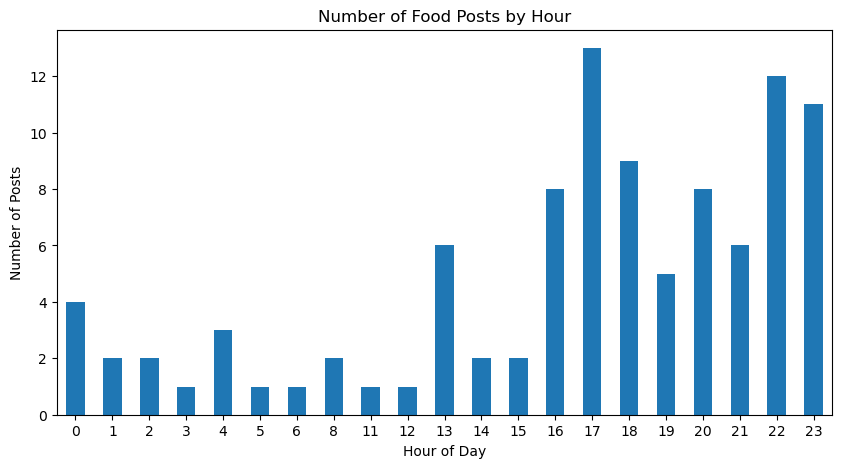

In [32]:
import matplotlib.pyplot as plt

posts_per_hour = df['hour'].value_counts().sort_index()

plt.figure(figsize=(10,5))
posts_per_hour.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Posts')
plt.title('Number of Food Posts by Hour')
plt.xticks(rotation=0)
plt.show()


### Engagement by Time Group 

<Figure size 600x500 with 0 Axes>

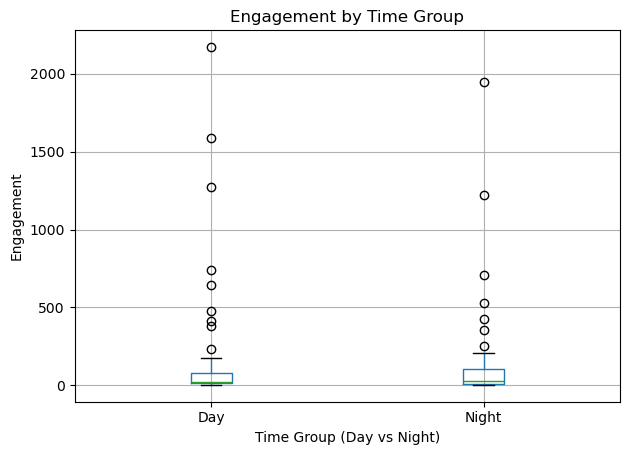

In [33]:
plt.figure(figsize=(6,5))
df.boxplot(column='engagement', by='time_group')
plt.title('Engagement by Time Group')
plt.suptitle('')
plt.xlabel('Time Group (Day vs Night)')
plt.ylabel('Engagement')
plt.tight_layout()
plt.show()


### Average Engagement by Hours

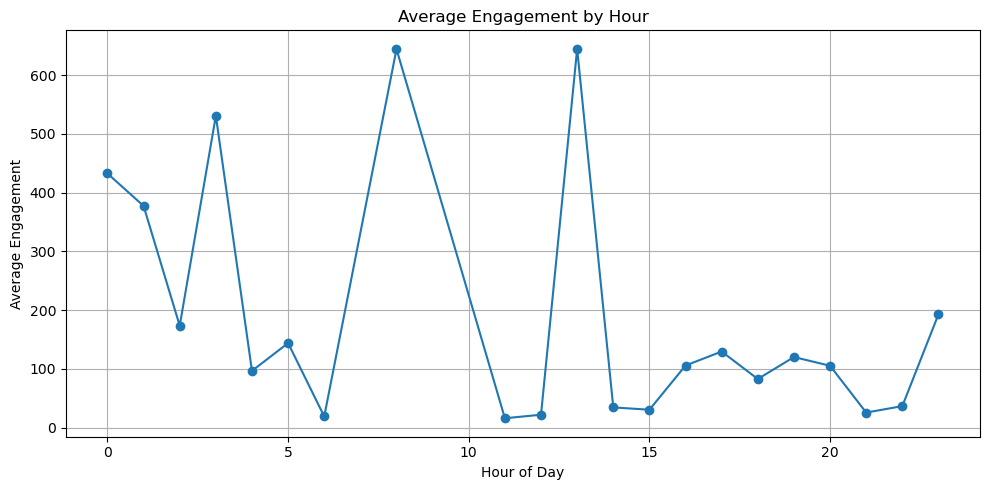

In [34]:
avg_engagement_by_hour = df.groupby('hour')['engagement'].mean()

plt.figure(figsize=(10,5))
avg_engagement_by_hour.plot(kind='line', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Engagement')
plt.title('Average Engagement by Hour')
plt.grid(True)
plt.tight_layout()
plt.show()


# 7. Results & Interpretation
The data shows that daytime posts had a higher average engagement than nighttime posts (245 vs 117). When looking at the top 10 most engaging posts, 8 were posted during the day which further supports this pattern.
To test whether this difference was statistically meaningful, I performed an independent samples t-test.
T-test


In [35]:
from scipy.stats import ttest_ind

day_eng = df[df['time_group']=="Day"]['engagement']
night_eng = df[df['time_group']=="Night"]['engagement']

t_stat, p_val = ttest_ind(day_eng, night_eng, equal_var=False)
t_stat, p_val


(np.float64(0.5619108393848522), np.float64(0.5755616438717714))

This means the difference is not statistically significant at 95% confidence.
### Interpretation
While daytime posts typically showed higher engagement and included most of the top-performing posts, the stats and evidence is not strong enough to say that posting time alone causes higher engagement. Other factors such as image quality, recipe appeal, or how unique the content is, play a more important role.


# 8. Limitations & Future Work
### Limitations
Data comes only from the hot feed, which favors posts already gaining engagement.
Engagement is influenced by content quality, not just timing.
Time zone differences could affect the factor of “day” vs “night.”
Single-day data collection limits the generalization.
### Future Improvements
Gather data over multiple days or weeks.
Include multiple food-related subreddits.
Classify content types (recipe, meal pic, question, etc.).
Compare weekday vs weekend trends.


# 9. Conclusion
In this dataset, daytime posts received higher engagement on average than nighttime posts, but the difference was not statistically significant. This suggests that while posting during the day may provide some advantages, engagement depends more on the content itself, than on timing.
This project demonstrates a full data workflow, from collection to processing, analysis, visualization, and interpretation, and it shows that posting time alone does not determine engagement levels on Reddit.


# USE OF AI
I used the free version of ChatGPT to help with formatting, organization, grammar, headings, sentence phrasing, and ensuring the project met the rubric requirements.
